# Data analysis

Analysis of the dataset introduced in [1]

[1] Willett, F.R., Kunz, E.M., Fan, C. et al. A high-performance speech neuroprosthesis. Nature 620, 1031–1036 (2023). https://doi.org/10.1038/s41586-023-06377-x

## Data Import

In [1]:
from src.args.base_args import B2TDatasetArgsModel
from src.datasets.brain2text import Brain2TextDataset
from src.args.yaml_config import YamlConfig
from typing import Literal
import numpy as np
import pandas as pd
from src.args.yaml_config import YamlConfig

In [2]:
def get_dataset(split: Literal['train', 'val', 'test'], preprocessing_mode: Literal[
        "competition_recommended",
        "seperate_zscoring",
        "only_tx_unnormalized",
        "only_tx_zscored",
        "only_spikepow_unnormalized",
        "only_spikepow_zscored",
    ]):
    config = B2TDatasetArgsModel()
    yaml_config = YamlConfig().config
    config.preprocessing = preprocessing_mode
    brain_data = Brain2TextDataset(
        config=config, yaml_config=yaml_config, split=split
    ).brain_data_samples
    brain_data = [sample.numpy() for sample in brain_data]
    return brain_data

def transform_and_pad(arr, max_x):
    padding = max_x - arr.shape[0]
    return np.pad(arr, [(0, padding), (0, 0)], mode='constant', constant_values=np.nan)

def merge_train_test_sentences(train_data, test_data):
    max_x = max(
        max(arr1.shape[0] for arr1 in train_data),
        max(arr2.shape[0] for arr2 in test_data)
    )

    padded_train = [transform_and_pad(arr, max_x) for arr in train_data]
    padded_test = [transform_and_pad(arr, max_x) for arr in test_data]
    padded_all = np.concatenate([padded_train, padded_test])

    index_levels = [
        np.repeat(np.arange(len(train_data) + len(test_data)), max_x),
        np.tile(np.arange(max_x), len(train_data) + len(test_data))
    ]

    df = pd.DataFrame(
        padded_all.reshape(-1, padded_all.shape[-1]),
        index=index_levels, 
        columns=range(padded_all.shape[-1])
    )
    return df
    

In [3]:
config = YamlConfig(config_path="config.yaml").config

## Analysis

In [4]:
from analysis.helpers import show_hist, show_statistics, show_heatmap, show_clusters, write_graph_per_feature

### Spike Power

Description by the dataset authors:

S x 1 vector containing a time series of spike power neural features for each sentence (S = number of sentences). 

Each entry is a T x F matrix of binned spike band power (20 ms bins), where T = number of time steps in the sentence and F = number of channels (256). 

Spike band power was defined as the mean of the squared voltages observed on the channel after high-pass filtering (250 Hz cutoff; units of microvolts squared). 

The data was denoised with a linear regression reference technique. 

The channels correspond to the arrays as follows (where 000 refers to the first column of spikePow and 255 refers to the last)

In [5]:
train_spike_pow_samples = get_dataset("train", "only_spikepow_unnormalized")
# val_spike_pow_samples = get_dataset("val", "only_spikepow_unnormalized")
test_spike_pow_samples = get_dataset("test", "only_spikepow_unnormalized")
spike_pow_concat = np.concatenate([np.concatenate(train_spike_pow_samples), np.concatenate(test_spike_pow_samples)])
sentences_df = merge_train_test_sentences(train_spike_pow_samples, test_spike_pow_samples)
spike_pow_concat.shape

Got tokenizer from file
Got tokenizer from file


(3033240, 128)

In [6]:
show_statistics(spike_pow_concat.flatten())

Summary
Min: 35.23589324951172, Max: 331745.0625
Mean: 1066.985595703125
Var: 1793050.5046182321


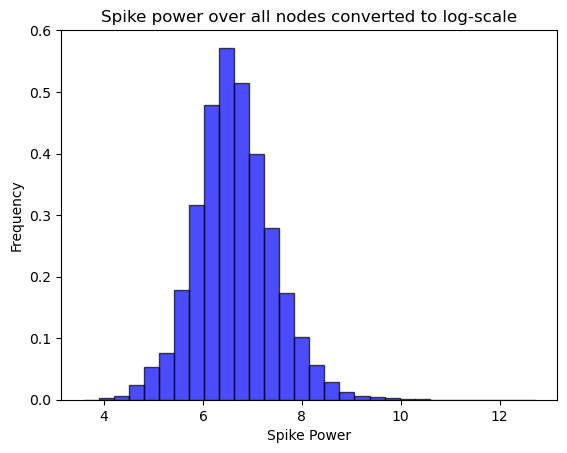

In [7]:
show_hist(spike_pow_concat.flatten(), "Spike Power", "Spike power over all nodes", log_scale=True)

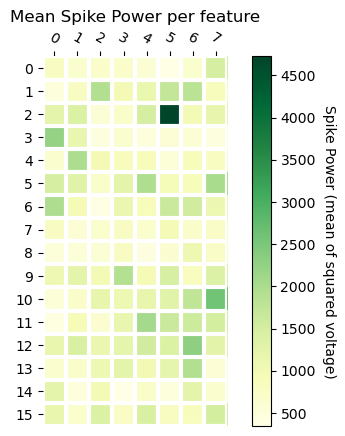

In [8]:
mean_per_feature = spike_pow_concat.mean(axis=0).reshape(((16,8)))
show_heatmap(mean_per_feature, "Mean Spike Power per feature")

PCA
50%: 5, 95%: 75


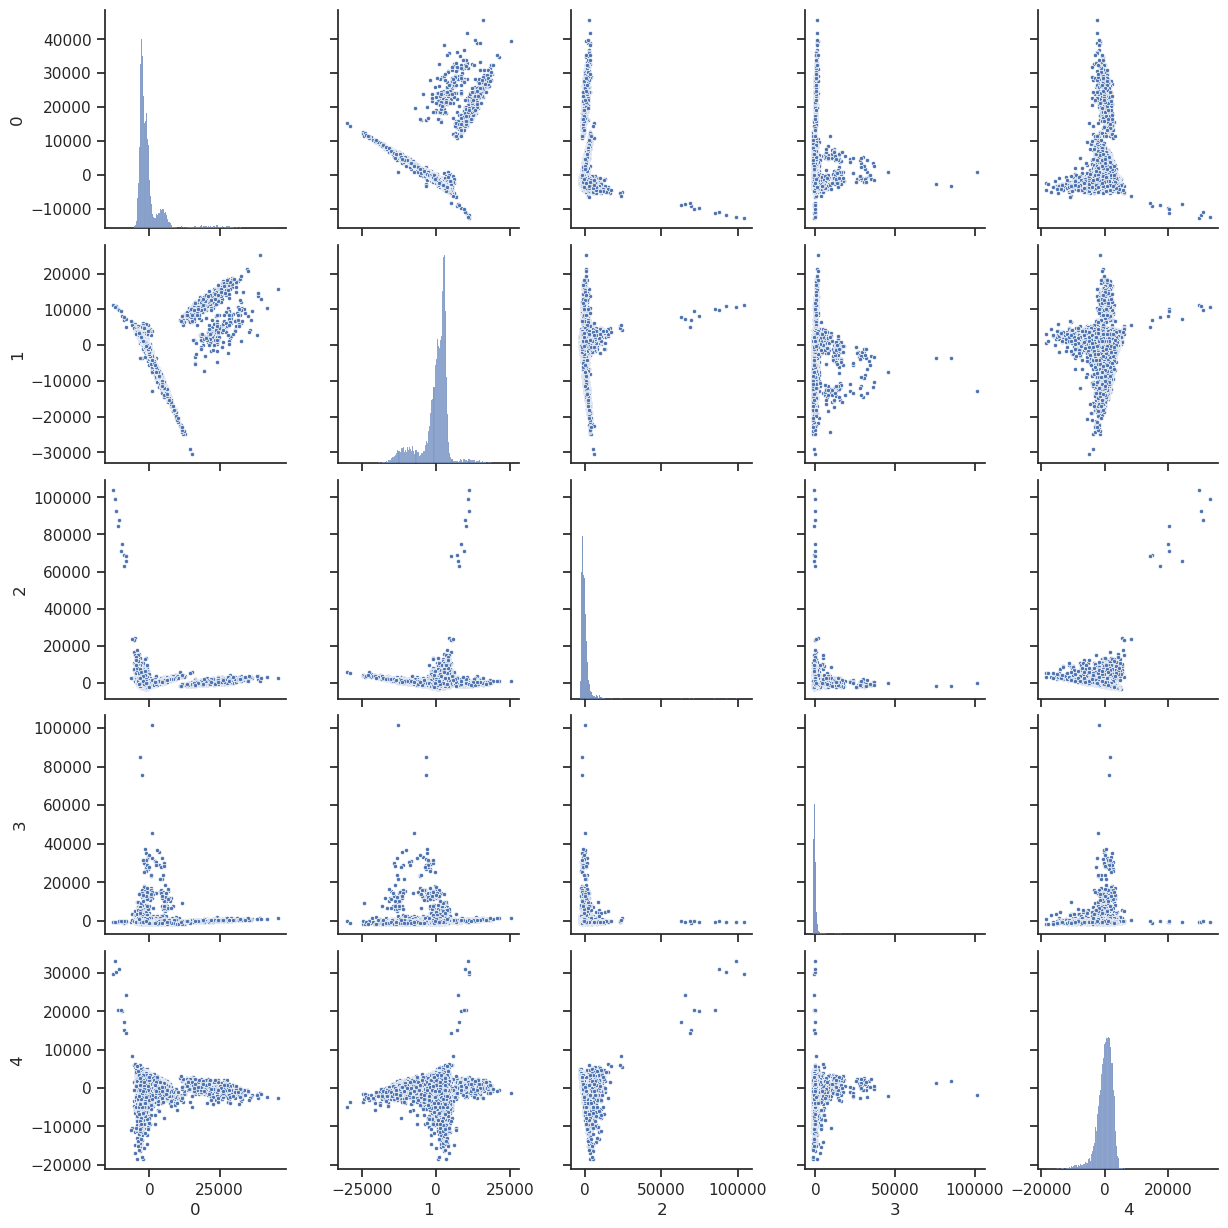

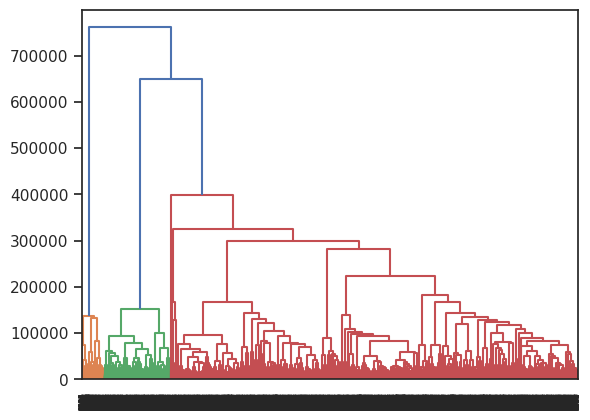

/hpi/fs00/home/leon.hermann/mambaforge/envs/b2t/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


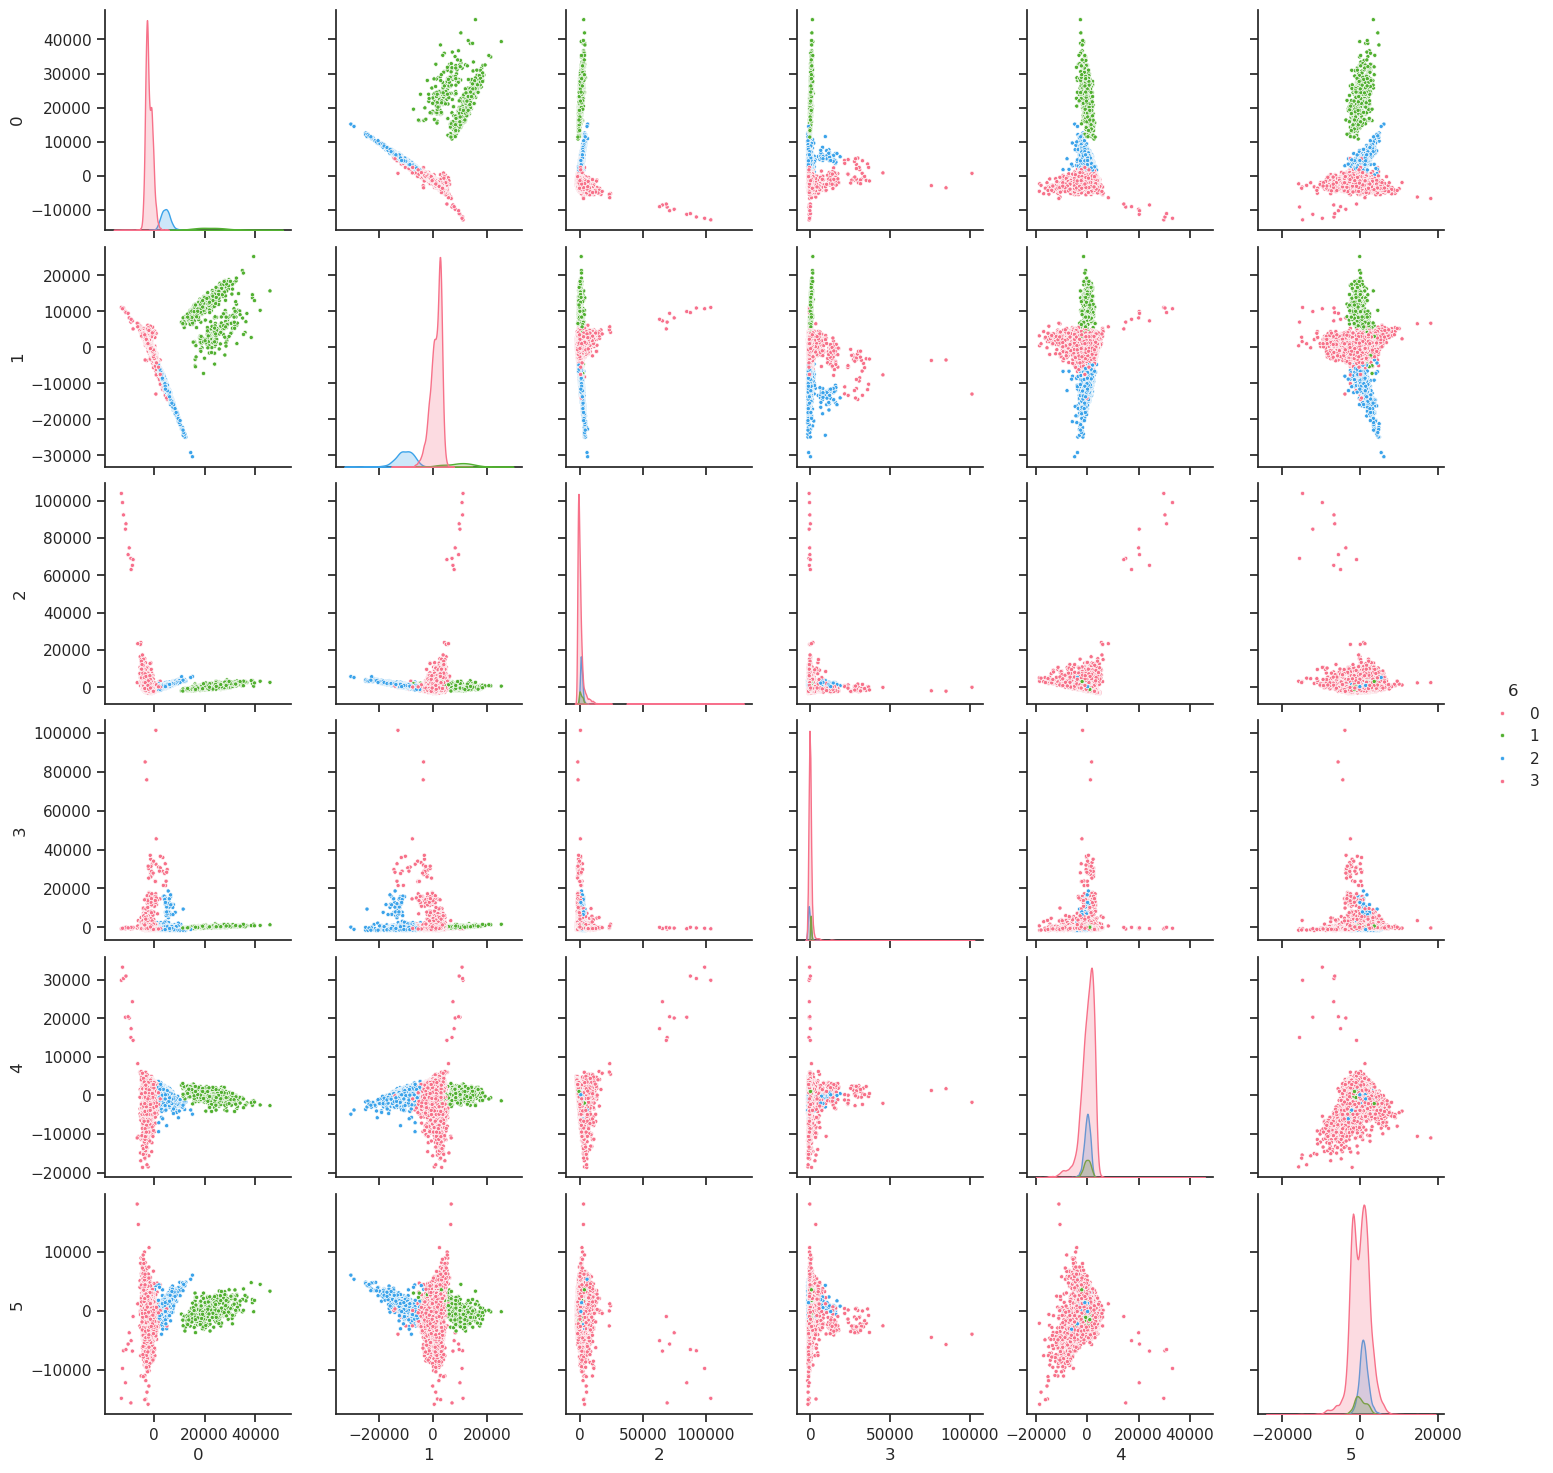

In [9]:
show_clusters(spike_pow_concat, 4, 10000)

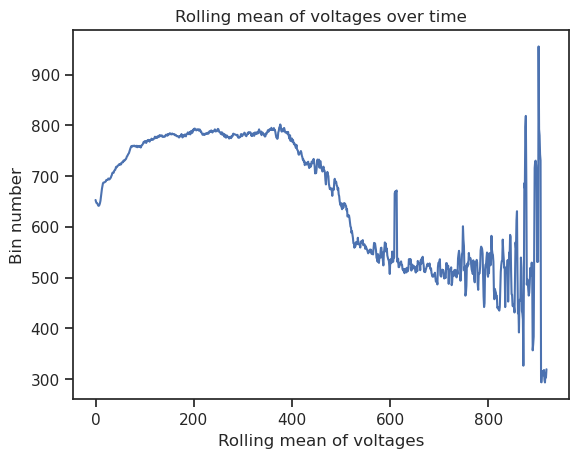

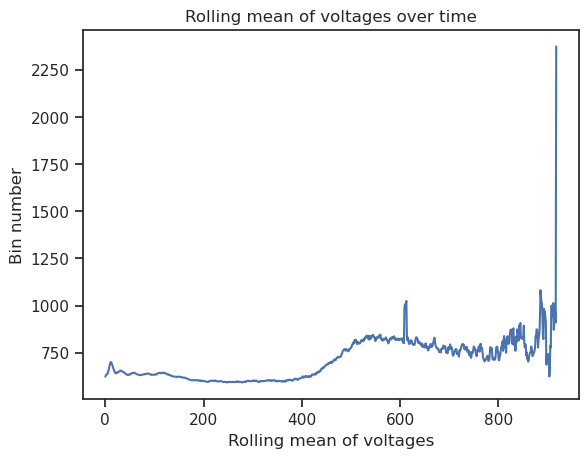

In [10]:
write_graph_per_feature(sentences_df, name='spike_pow', save_path=config.fig_dir, show_features=[0, 1])

### Spike count (tx1)

Description by dataset authors:

S x 1 vector containing a time series of threshold crossing neural features for each sentence (S = number of sentences). 

Each entry is a T x F matrix of binned threshold crossing counts (20 ms bins), where T = number of time steps in the sentence and F = number of channels (256). 

The data was denoised with a linear regression reference technique and a -3.5 x RMS threshold was used. 

The channels correspond to the arrays in the same way as spikePow described above. 

Note that threshold crossing counts describe the number of times the voltage recorded on an electrode crossed a threshold within a given time bin (essentially, this roughly counts the number of nearby action potentials observed on an elctrode in a given time bin).

In [12]:
train_spike_count_samples = get_dataset("train", "only_tx_unnormalized")
# val_spike_pow_samples = get_dataset("val", "only_spikepow_unnormalized")
test_spike_count_samples = get_dataset("test", "only_tx_unnormalized")
spike_counts = np.concatenate([np.concatenate(train_spike_count_samples), np.concatenate(test_spike_count_samples)])
sentences_df = merge_train_test_sentences(train_spike_count_samples, test_spike_count_samples)

spike_counts.shape

Got tokenizer from file
Got tokenizer from file


/hpi/fs00/home/leon.hermann/mambaforge/envs/b2t/lib/python3.11/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/hpi/fs00/home/leon.hermann/mambaforge/envs/b2t/lib/python3.11/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]


(3033240, 128)

In [13]:
show_statistics(spike_counts.flatten())

Summary
Min: 0, Max: 34
Mean: 0.6454329441249291
Var: 0.7670751656293399


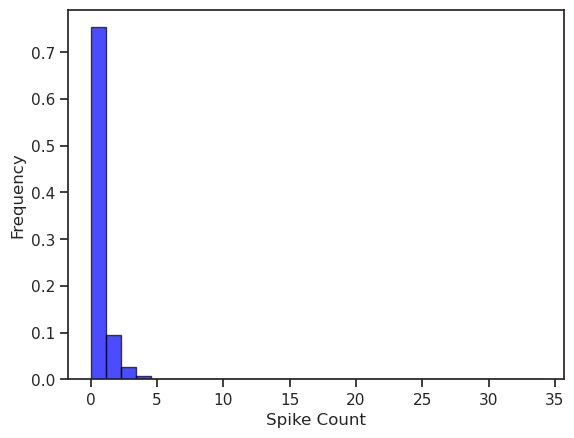

In [14]:
show_hist(spike_counts.flatten(), "Spike Count", "Spike count over all nodes")

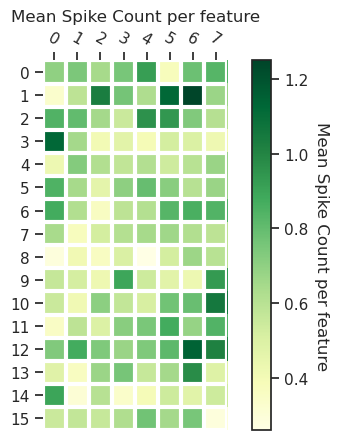

In [15]:
mean_per_feature = spike_counts.mean(axis=0).reshape(((16,8)))
show_heatmap(mean_per_feature, "Mean Spike Count per feature", "Mean Spike Count per feature")

PCA
50%: 44, 95%: 115


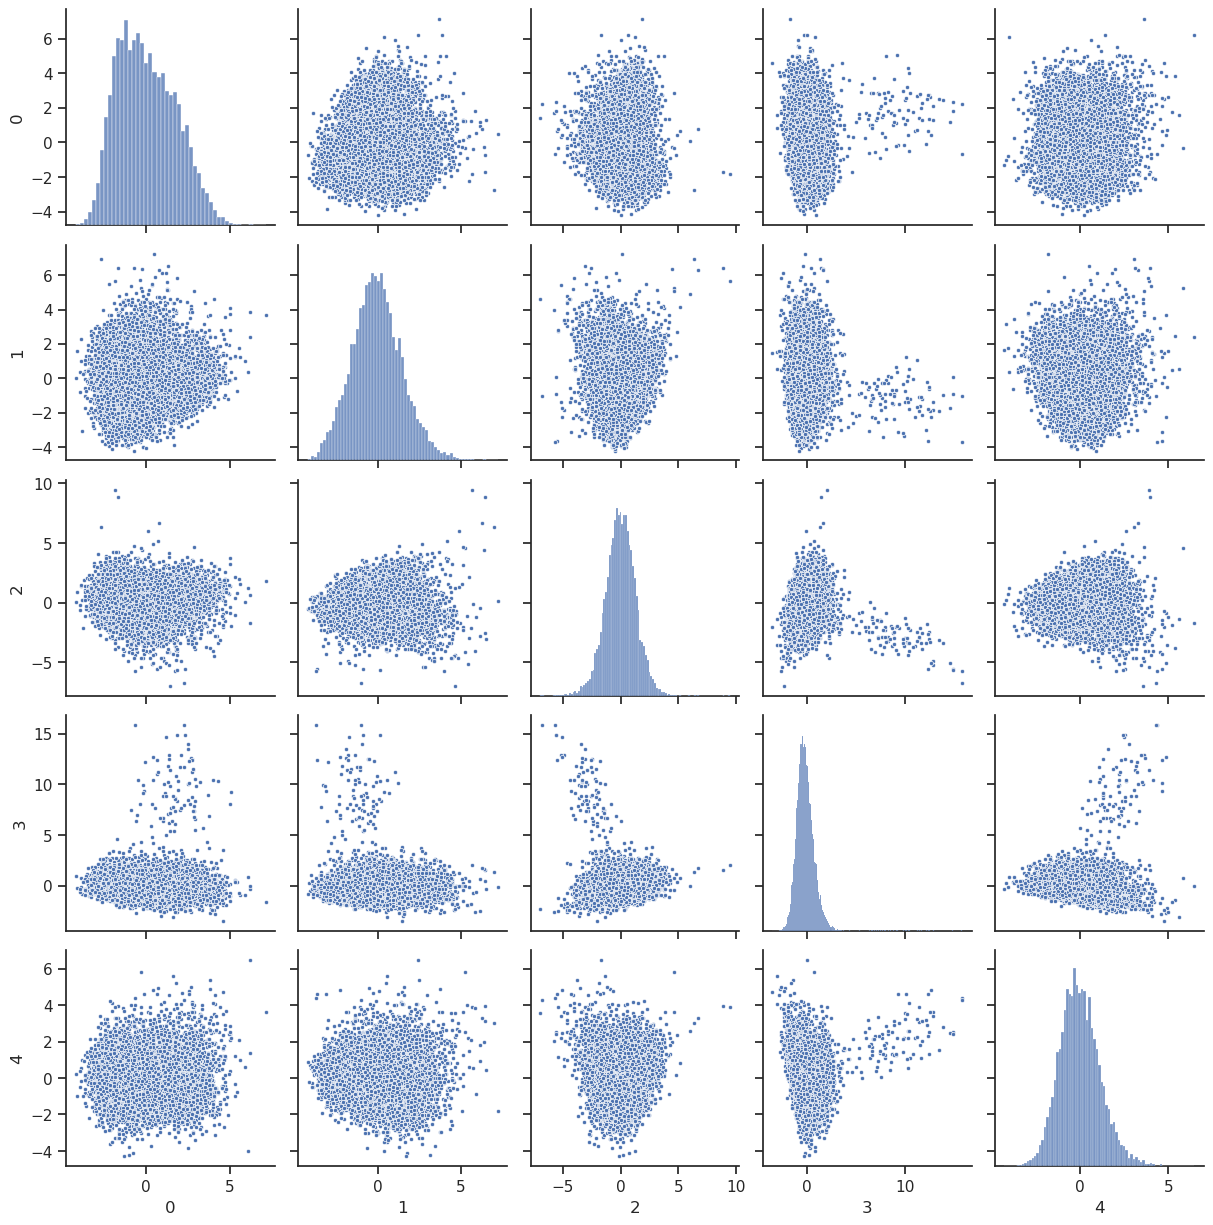

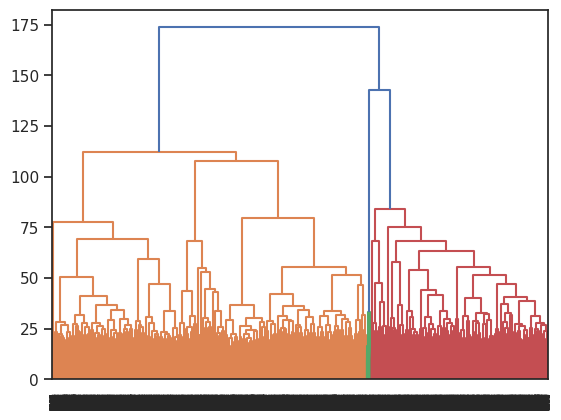

/hpi/fs00/home/leon.hermann/mambaforge/envs/b2t/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


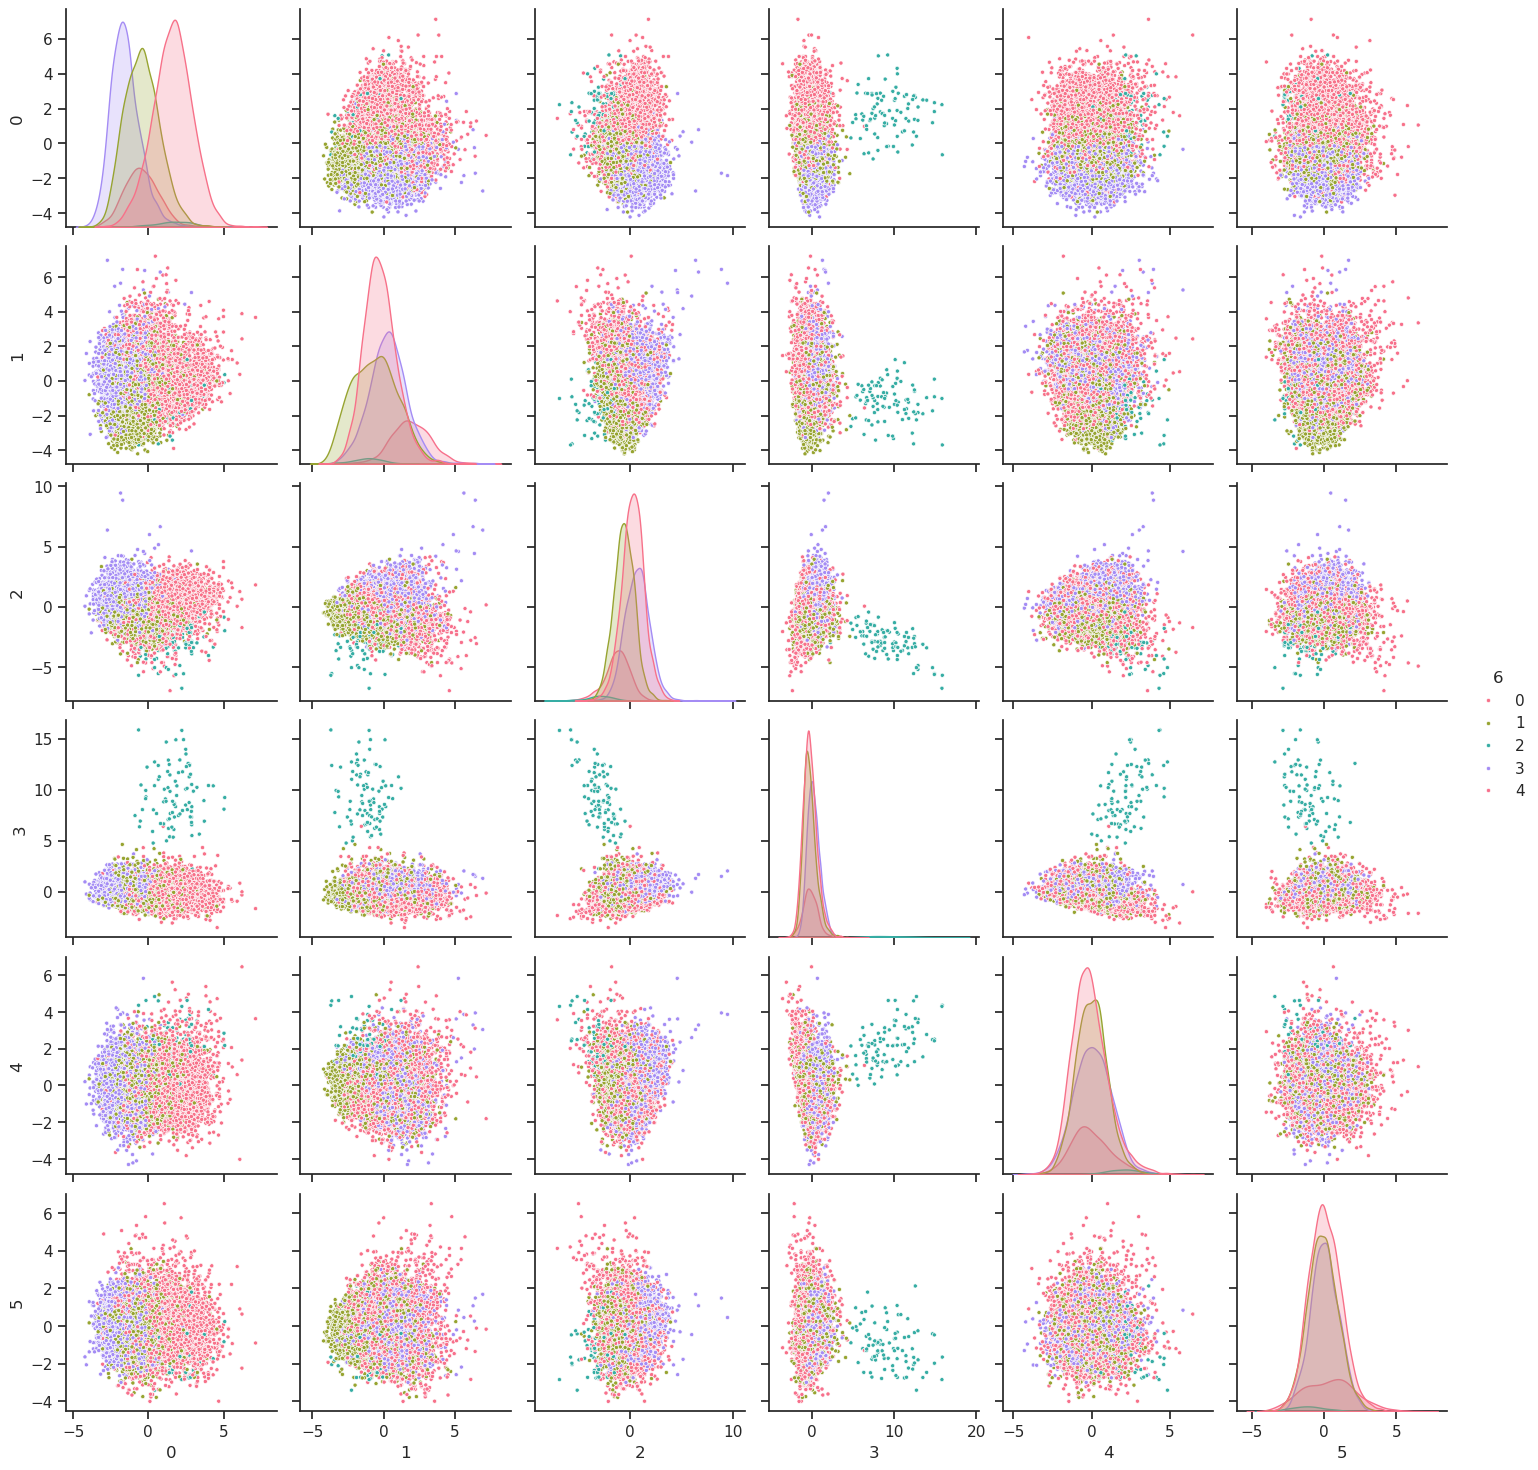

In [16]:
show_clusters(spike_counts, num_cluster=5, samples=10000)

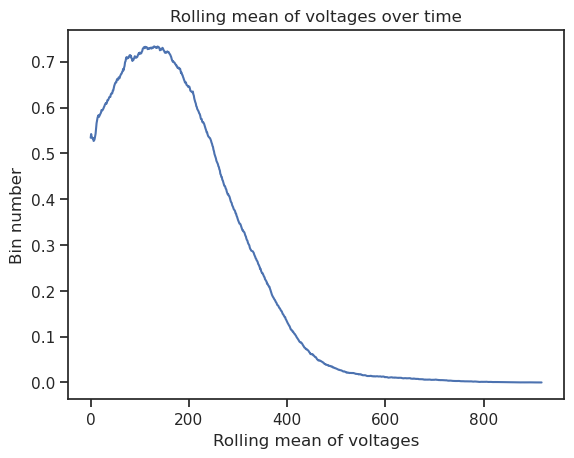

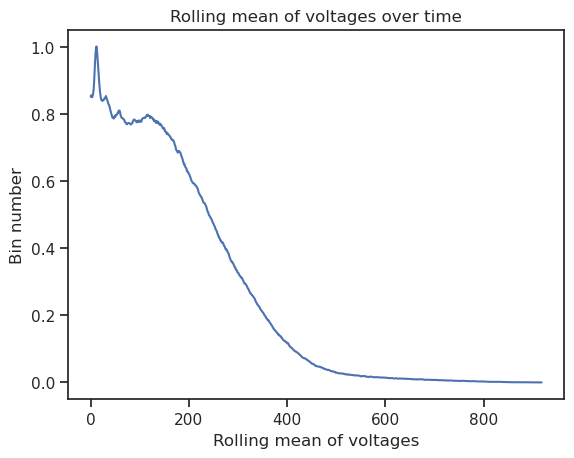

In [17]:
write_graph_per_feature(sentences_df, name="spike_count", save_path=config.fig_dir, show_features=[0, 1])